In [1]:
#### Brasil ####
pacotes <- c("rbcb","tidyverse","MASS")
for(i in pacotes){
  suppressPackageStartupMessages(library(i, character.only = T))
}

In [2]:
#### Coletando os dados ####
meta <- get_series(c(Meta = 13521))
inflacao <- get_series(c(IPCA = 13522), start_date = first(meta$date))
selic <- get_series(c(Selic = 432), start_date = first(meta$date))

In [3]:
#### Ajustando os dados ####
datas <- seq(first(meta$date), Sys.Date(), "1 month")
data <- data.frame(Meta = NA, date = datas)
tot <- left_join(data, meta, by = c("date"="date"))
tot$Meta.x <- NULL
colnames(tot) <- c("date","Meta")
for(i in 2:nrow(tot)){
  if(is.na(tot[i,2])){
    tot[i,] <- tot[i-1,]
  }
}

In [4]:
#### Agregando os dados ####
tot$date <- datas
total <- left_join(inflacao,tot, by = c("date"="date"))
total <- left_join(total, selic, by = c("date"="date"))
total <- na.omit(total)

In [5]:
#### Calculando a taxa de equilíbrio pela regra de Taylor ####
total$taylor <- 0.5*(total$IPCA-total$Meta)+4.5+total$IPCA
total[,-1] <- total[,-1]/100
#Resíduos#
total$residuos_2 <- (total$Selic-total$taylor)^2
total$residuos <- total$Selic-total$taylor
total$Taxa_real <- (1+total$Selic)/(1+total$IPCA)-1

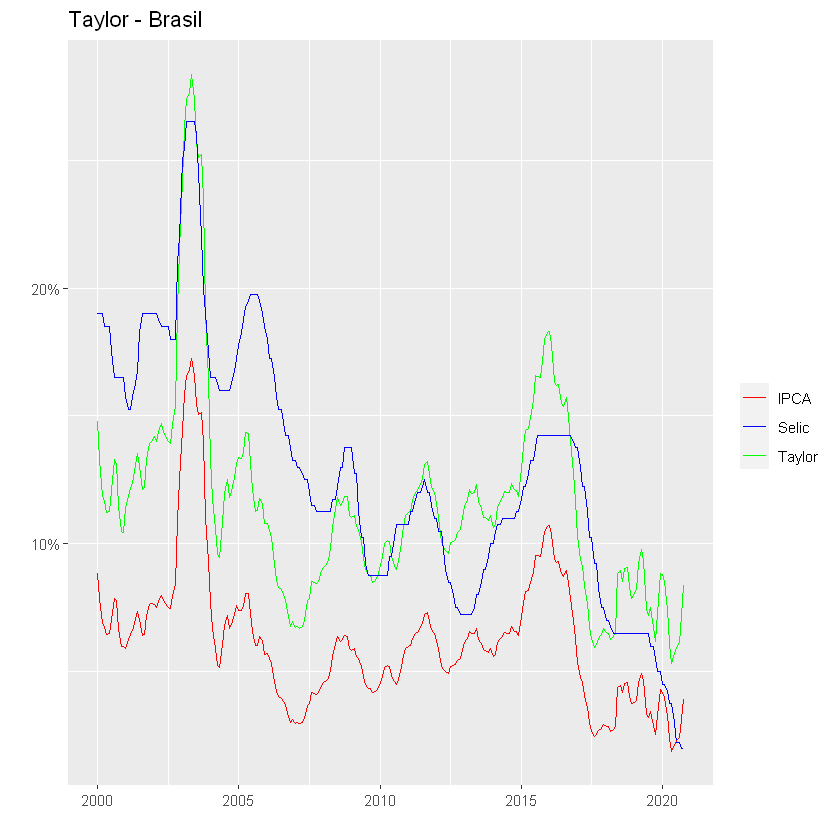

In [6]:
#### Plotando os dados ####
total %>%
  filter(date >= "2000-01-01") %>%
  ggplot(aes(x = date))+
  geom_line(aes(y = taylor, col = "Taylor"))+
  geom_line(aes(y = Selic, col = "Selic"))+
  geom_line(aes(y = IPCA, col = "IPCA"))+
  scale_color_manual("", values = c("red","blue","green"))+
  scale_y_continuous(labels = scales::percent)+
  labs(x = "", y = "", title = "Taylor - Brasil")

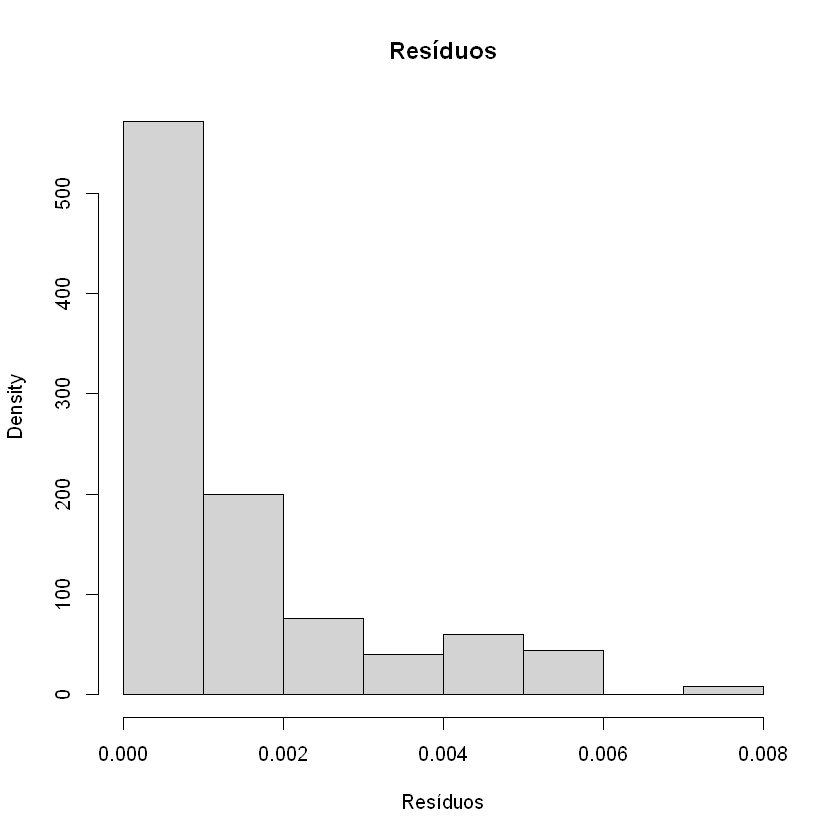

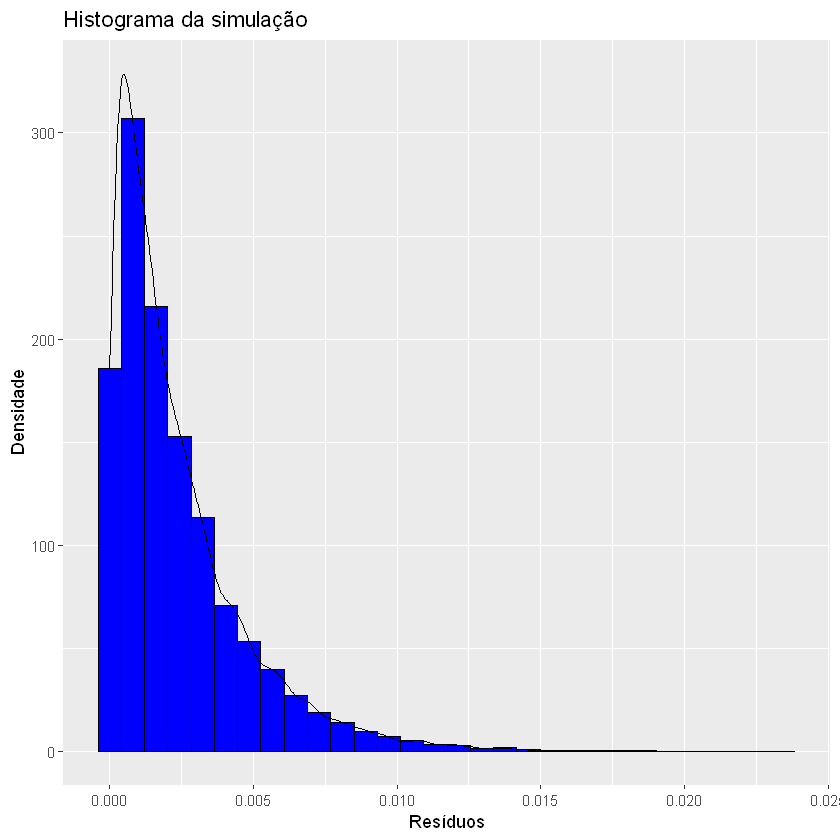

In [7]:
#### Estimando a distribuição dos resíduos entre a Selic e a taxa de equilíbrio ####
fit <- fitdistr(total$residuos_2,"exponential")
sim <- data.frame(Simulacao = rexp(10000,fit$estimate))
hist(total$residuos_2[which(total$date >= "2000-01-01")], freq = F, xlab = "Resíduos", main = "Resíduos")
ggplot(sim, aes(x = Simulacao, y = after_stat(density)))+
  geom_histogram(bins = 30, fill = "blue", col = "black")+
  geom_density()+
  labs(x = "Resíduos", y = "Densidade", title = "Histograma da simulação")

In [8]:
#### USA ####
library(fredr)

In [9]:
#### Coletando os dados ####
fredr_set_key("a1e53d11bf4cb319624da39b894a79e6")
fed_funds <- fredr("FEDFUNDS")
inflation <- fredr("CPIAUCSL", units = "pc1",
                   observation_start = first(fed_funds$date))
potential <- fredr("NGDPPOT", observation_start = first(fed_funds$date))
gdp <- fredr("GDP", observation_start = first(fed_funds$date))
colnames(inflation) <- c(colnames(inflation)[-3],"CPI")
colnames(potential) <- c(colnames(potential)[-3],"Potential")
colnames(gdp) <- c(colnames(gdp)[-3],"GDP")
colnames(fed_funds) <- c(colnames(fed_funds)[-3],"Rate")
inflation[,2] <- NULL
gdp[,2] <- NULL
potential[,2] <- NULL
fed_funds[,2] <- NULL

In [10]:
#### Agregando e modificando os dados ####
tot <- left_join(inflation,potential, by = c("date" = "date"))
tot <- left_join(tot,gdp, by = c("date"="date"))
tot <- left_join(tot,fed_funds, by = c("date"="date"))
for(i in 2:nrow(tot)){
  for(j in 1:ncol(tot)){
    if(is.na(tot[i,j])){
      tot[i,j] <- tot[i-1,j]
    }
  }
}
tot <- tot %>%
  mutate(Gap = (GDP-Potential)/Potential,
         CPI = CPI/100, Rate = Rate/100,
         Expectation = 0.02,
         Difference = CPI-Expectation,
         Taylor = 0.5*Gap+0.5*Difference+CPI+0.02,
         residuals_2 = (Taylor-Rate)^2,
         residuals = (Rate-Taylor),
         Real_int = (1+Rate)/(1+CPI)-1)

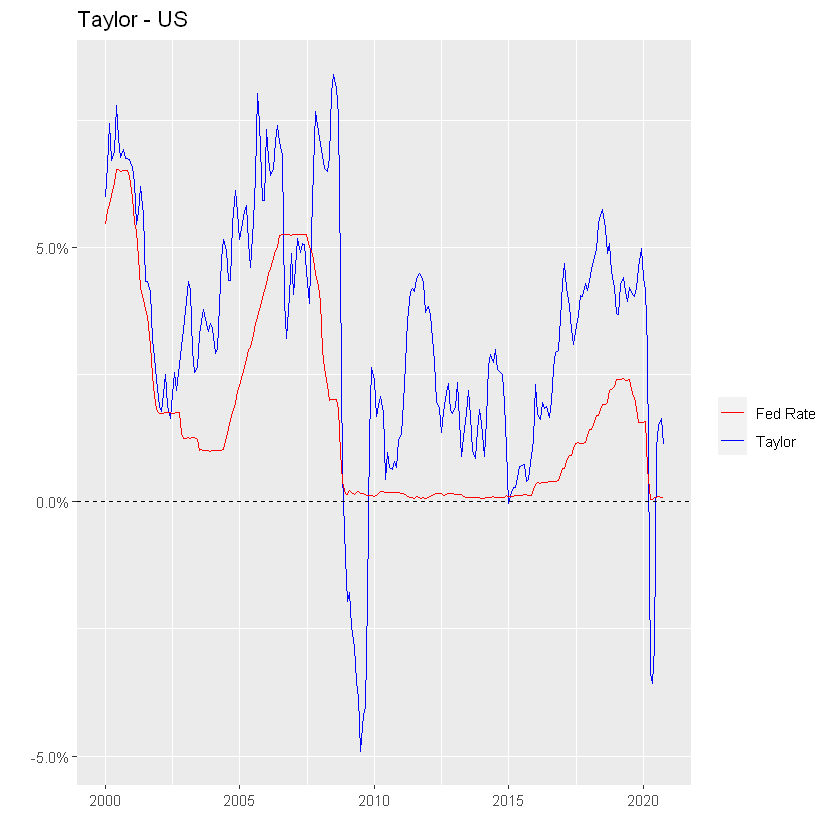

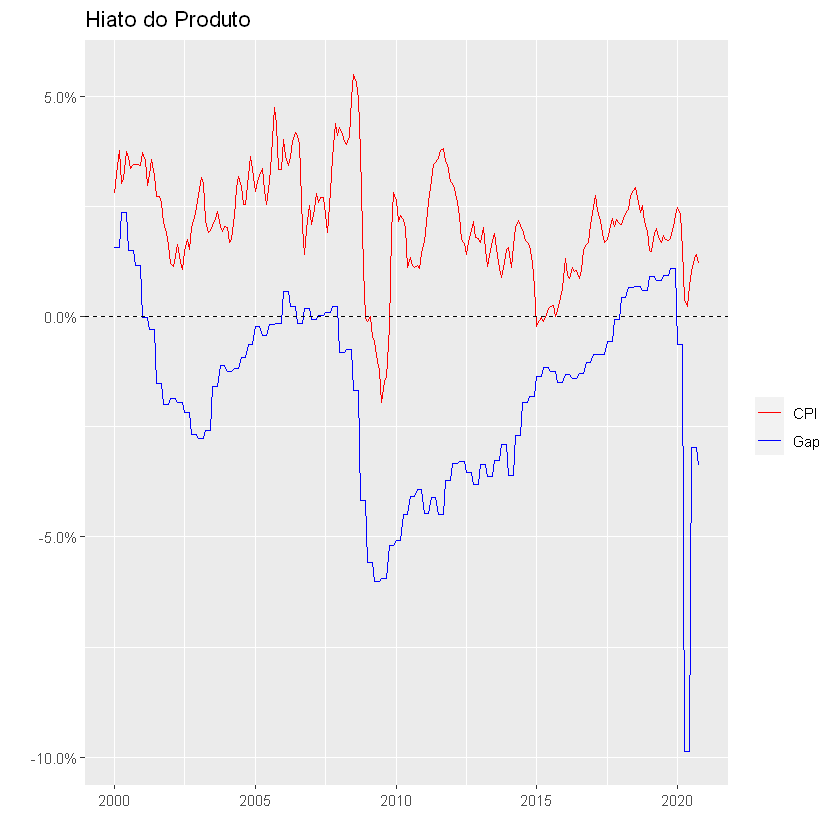

In [14]:
#### Plotando os gráficos ####
data_ref <- "2000-01-01"
tot %>%
  filter(date >= data_ref) %>%
  ggplot(aes(x = date))+
  geom_line(aes(y = Taylor, col = "Taylor"))+
  geom_line(aes(y = Rate, col = "Fed Rate"))+
  scale_y_continuous(labels = scales::percent)+
  scale_color_manual("", values = c("red","blue"))+
  geom_hline(yintercept = 0, lty = 2)+
  labs(x = "", y = "", title = "Taylor - US")
tot %>%
  filter(date >= data_ref) %>%
  ggplot(aes(x = date))+
  geom_line(aes(y = Gap, col = "Gap"))+
  geom_line(aes(y = CPI, col = "CPI"))+
  geom_hline(yintercept = 0, lty = 2)+
  scale_y_continuous(labels = scales::percent)+
  scale_color_manual("", values = c("red","blue"))+
  labs(x = "", y = "", title = "Hiato do Produto")

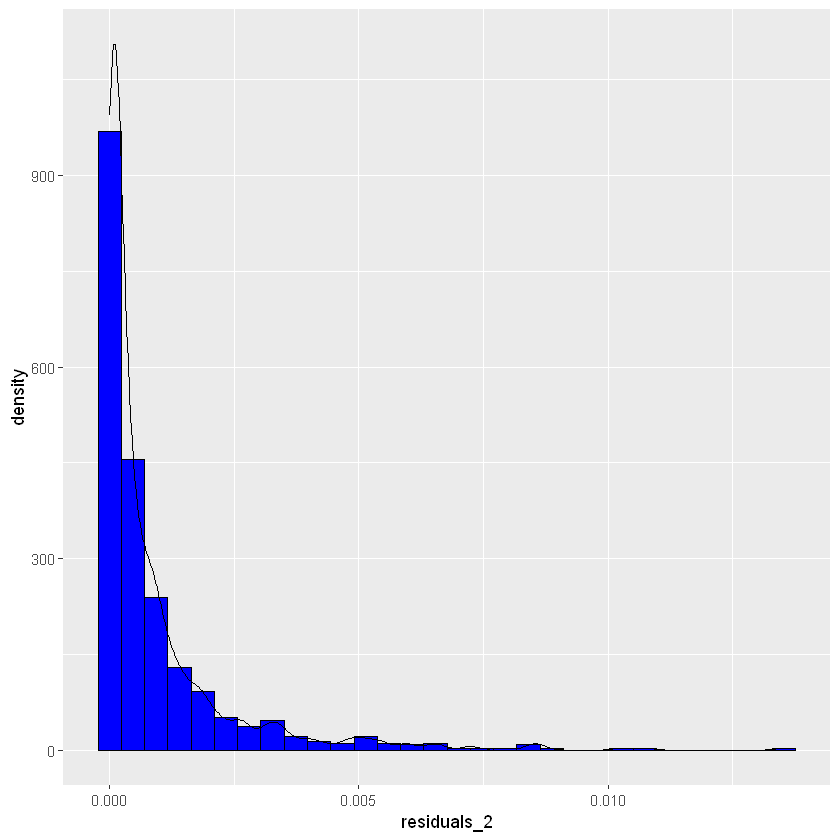

In [12]:
#### Resíduos ####
ggplot(tot, aes(x = residuals_2, y = after_stat(density)))+
  geom_histogram(bins = 30, fill = "blue", col = "black")+
  geom_density()
fit <- fitdistr(tot$residuals_2,"exponential")
sim <- data.frame(Simulacao = sqrt(rexp(10000,fit$estimate)))

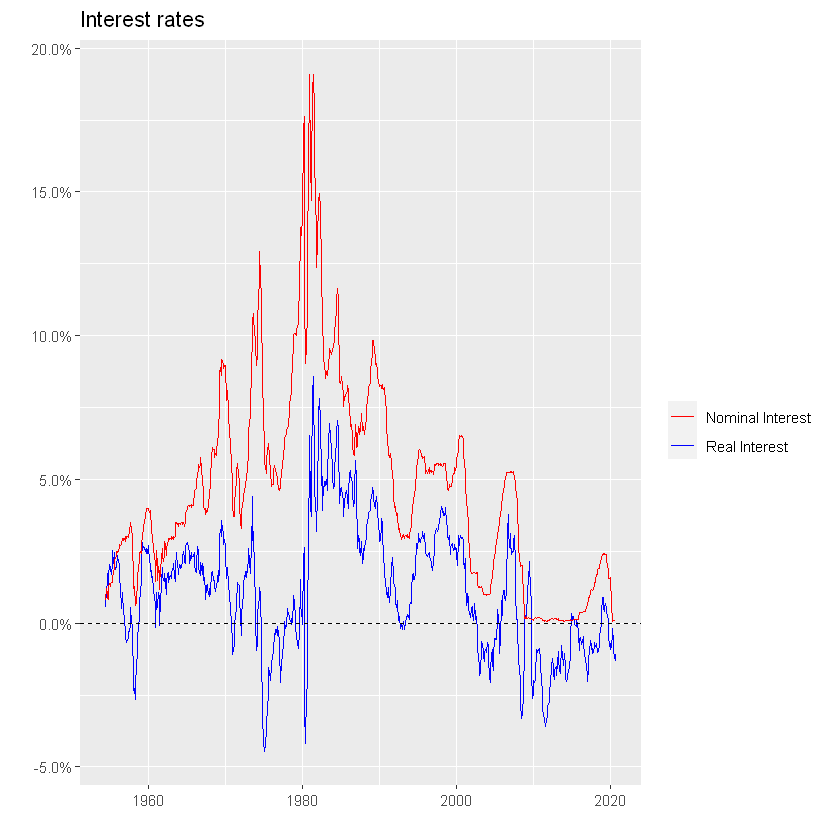

In [13]:
ggplot(tot, aes(x = date))+
  geom_line(aes(y = Real_int, col = "Real Interest"))+
  geom_line(aes(y = Rate, col = "Nominal Interest"))+
  scale_y_continuous(labels = scales::percent)+
  geom_hline(yintercept = 0, lty = 2)+
  scale_color_manual("", values = c("red","blue"))+
  labs(x = "", y = "", title = "Interest rates")